# Facial recognition with CNN. 
### This a project to recognize only the face of Chukwunenye (chuks). All other faces detected are to be tagged as not chuks
### The CNN architecture to be used is a pretrained MobileNet Architecture 



## Importing all the libraries to be used:

In [7]:
import shutil
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os

# Importing the dataset for training

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!cp -r "/content/gdrive/MyDrive/face_pics.zip" "/content"

In [4]:
from zipfile import ZipFile
archive = ZipFile('/content/face_pics.zip')
archive.extractall('/content')

In [5]:
# setting up directories
#dataset_path = '/content/training_pictures'

chuks_path = '/content/face_pics/training_pictures/chukspics'
notchuks_path = '/content/face_pics/training_pictures/otherpictures'

train_path='/content/face_pics/training_pictures'
test_path = '/content/face_pics/test_pictures'



In [9]:
img = cv2.imread('/content/face_pics/training_pictures/chukspics/chuks0.png', cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (480, 640, 3)
Image Height       :  480
Image Width        :  640
Number of Channels :  3


In [10]:
img = cv2.imread('/content/face_pics/training_pictures/otherpictures/AA5742_id154_s0_62 - Copy.png', cv2.IMREAD_UNCHANGED)
 
# get dimensions of image
dimensions = img.shape
 
# height, width, number of channels in image
height = img.shape[0]
width = img.shape[1]
channels = img.shape[2]
 
print('Image Dimension    : ',dimensions)
print('Image Height       : ',height)
print('Image Width        : ',width)
print('Number of Channels : ',channels)

Image Dimension    :  (657, 657, 3)
Image Height       :  657
Image Width        :  657
Number of Channels :  3


In [11]:
category=['chuk','notchuks']

In [12]:
# Importing necessary Keras libraries for the AI model

from keras.layers import Dense,Dropout,Input,Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import model_from_json
import json

###### Data augumentaion

In [13]:

train_datagen = ImageDataGenerator(brightness_range=(0.8,1.2),
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   fill_mode='nearest',
                                   shear_range=0.2,
                                   zoom_range=0.3,
                                   rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [14]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(160,160),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=25,
                                                    shuffle=True)

Found 108 images belonging to 2 classes.


In [15]:
valid_generator = valid_datagen.flow_from_directory(test_path,
                                                    target_size=(160,160),
                                                    color_mode='rgb',
                                                    class_mode='binary',
                                                    batch_size=25)

Found 38 images belonging to 2 classes.


### MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications” MobileNet is a streamlined architecture that uses Depthwise Separable convolutions to construct lightweight deep convolutional neural networks and provides an efficient model for mobile and embedded vision applications

In [16]:
mobilenet = MobileNetV2(weights="imagenet",
                        include_top=False,
                        input_tensor=Input(shape=(160,160,3)))

9406464/9406464 [==============================] - 0s 0us/step


In [17]:
mobilenet.trainable = False

In [18]:
output = Flatten()(mobilenet.output)
output = Dropout(0.3)(output)
output = Dense(units = 8,activation='relu')(output)
prediction = Dense(1,activation='sigmoid')(output)

In [21]:
# making an instance of the mobilenet model
model = Model(inputs = mobilenet.input,outputs = prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][0]']         

In [25]:
# Compiling the model
model.compile(
  loss='binary_crossentropy',
  optimizer=Adam(
    learning_rate=0.000001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
  metrics=['accuracy']
)

#### Model checkpoint: storing the weights of the cnn model

In [22]:
# Creating a directory to store model weights for model checkpoint
os.mkdir('/content/model_weights/')

In [23]:
# model checkpoint
model_checkpoint = ModelCheckpoint('./model_weights/chuks_model_{epoch:02d}-{val_accuracy:.6f}.h5',
                                   monitor='val_loss', 
                                   mode='min', 
                                   verbose=1, 
                                   save_best_only=True,
                                   save_weights_only=True)
     


##### Trained the model with 70 epochs

In [26]:
history = model.fit_generator(
    train_generator,
    #steps_per_epoch = train_generator.samples // 2,
    validation_data = valid_generator, 
    #validation_steps = valid_generator.samples // 2,
    epochs = 70,
    callbacks=[model_checkpoint])

<ipython-input-26-888af3742e9a>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/70
5/5 [==============================] - ETA: 0s - loss: 1.9640 - accuracy: 0.3981
Epoch 1: val_loss improved from inf to 1.06065, saving model to ./model_weights/chuks_model_01-0.447368.h5
5/5 [==============================] - 14s 1s/step - loss: 1.9640 - accuracy: 0.3981 - val_loss: 1.0607 - val_accuracy: 0.4474
Epoch 2/70
5/5 [==============================] - ETA: 0s - loss: 1.5317 - accuracy: 0.3981
Epoch 2: val_loss improved from 1.06065 to 1.03326, saving model to ./model_weights/chuks_model_02-0.447368.h5
5/5 [==============================] - 6s 1s/step - loss: 1.5317 - accuracy: 0.3981 - val_loss: 1.0333 - val_accuracy: 0.4474
Epoch 3/70
5/5 [==============================] - ETA: 0s - loss: 1.5477 - accuracy: 0.3981
Epoch 3: val_loss improved from 1.03326 to 1.00787, saving model to ./model_weights/chuks_model_03-0.447368.h5
5/5 [==============================] - 3s 515ms/step - loss: 1.5477 - accuracy: 0.3981 - val_loss: 1.0079 - val_accuracy: 0.4474
Epoch 4/70
5/

##### Saving the model as a JSON file

In [27]:
# serialize model to JSON
model_json = model.to_json()
with open("chuks_model.json", "w") as json_file:
    json_file.write(model_json)

### Performance/ Accuracy test

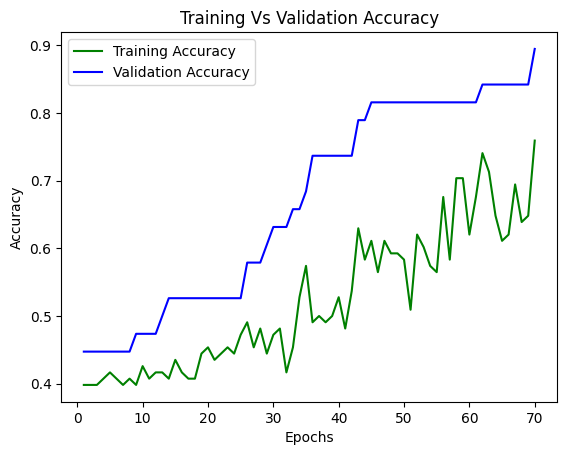

In [29]:
# Training Vs Validation Accuracy

train_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1,71)
plt.plot(epochs,train_accuracy,'g',label='Training Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

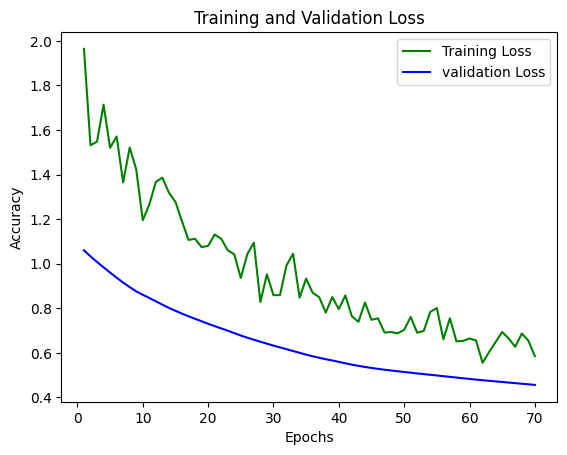

In [30]:
# Training and Validation Loss

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1,71)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### Testing the model by using different images to determine the performance of the model

In [31]:
# running predictions

from keras.utils import load_img, img_to_array
import numpy as np

def check_fakes(path,category_type):
  predictor = {}
  path= os.path.join(path,category_type)
  for img in os.listdir(path):
    try:
      img = load_img(os.path.join(path,img),target_size=(160,160))
      img = img_to_array(img)
      img = np.expand_dims(img,axis=0)
      img = img / 255.0
      prediction = model.predict(img)
      if prediction > 0.5:
        prediction_class = 1
      else:
        prediction_class = 0
      result = categories[prediction_class]
      if result not in predictor:
        predictor[result] = 1
      else:
        predictor[result] += 1
    except Exception as e:
      pass
  return predictor

In [32]:
def image_test(test_path):

    try:
      img = load_img(test_path,target_size=(160,160))
      img = img_to_array(img)
      img = np.expand_dims(img,axis=0)
      img = img / 255.0

      prediction = model.predict(img)

      if prediction > 0.5:
        prediction_class = 'notchuks'
      else:
        prediction_class = 'chuks'


      result = prediction_class
      
    except Exception as e:
      pass
    return 'The image is a {} image'.format(result)

#image_test(['path'])

In [33]:
image_test('/content/ebu1.png')

1/1 [==============================] - 1s 1s/step


'The image is a notchuks image'